In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['font.family']= 'NanumGothic' 
plt.rcParams['axes.unicode_minus']=False


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 불러오기
df = pd.read_csv("인구주택총조사_2%_인구사항(제공)_2020.csv", encoding='cp949')  # 실제 파일명으로 수정하세요

# 타겟 변수 정의: 수도권 외부 → 수도권 유입자 = 1, 수도권 내 이동 = 0
# 아래는 예시이며, 수도권 코드 기반으로 생성해야 합니다
def classify_movement(row):
    if (row['1년전거주지_타시도행정구역코드'] not in [31, 11,23]) and (row['행정구역시도코드'] in [31, 11,23]):
        return 1  # 비수도권 → 수도권
    elif (row['1년전거주지_타시도행정구역코드'] in [31, 11,23]) and (row['행정구역시도코드'] in [31, 11,23]):
        return 0  # 수도권 내 이동
    else:
        return None  # 제외

df['이동유형'] = df.apply(classify_movement, axis=1)
df = df.dropna(subset=['이동유형'])

from sklearn.preprocessing import LabelEncoder

# 사용 변수
features = [
    '만연령', '성별코드', '교육정도코드', '혼인상태코드',
    '출생지_타행정구역시도코드', '1년전거주지_타시도행정구역코드',
    '5년전거주지_타시도행정구역코드', '직업대분류코드',
    '산업대분류코드', '통근통학_타행정구역읍면동코드',
    '가구주관계코드'
]

X = df[features].copy()
y = df['이동유형']

# Label Encoding: 모든 object형 혹은 범주형 데이터를 숫자로 변환
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# 결측치 제거
X = X.dropna()
y = y.loc[X.index]

# 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 결과 출력
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5540
         1.0       1.00      0.99      1.00      6155

    accuracy                           1.00     11695
   macro avg       1.00      1.00      1.00     11695
weighted avg       1.00      1.00      1.00     11695



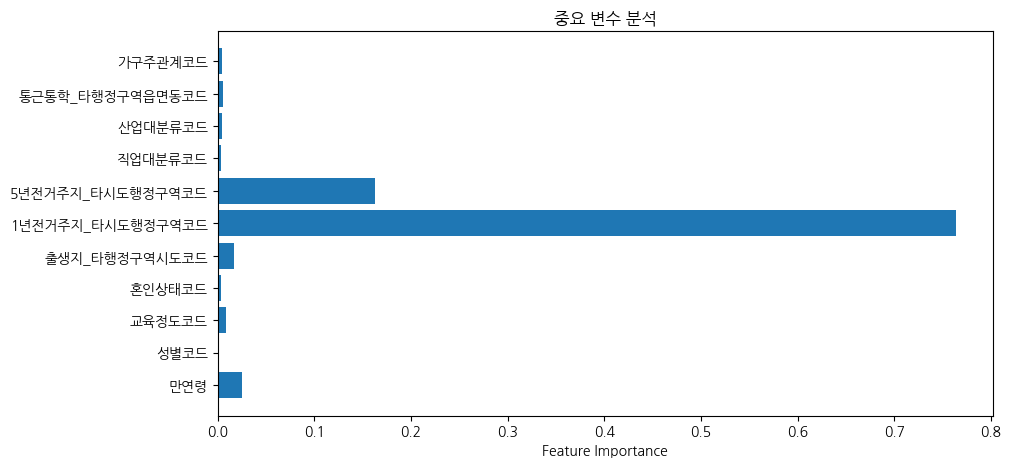

In [5]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("중요 변수 분석")
plt.show()


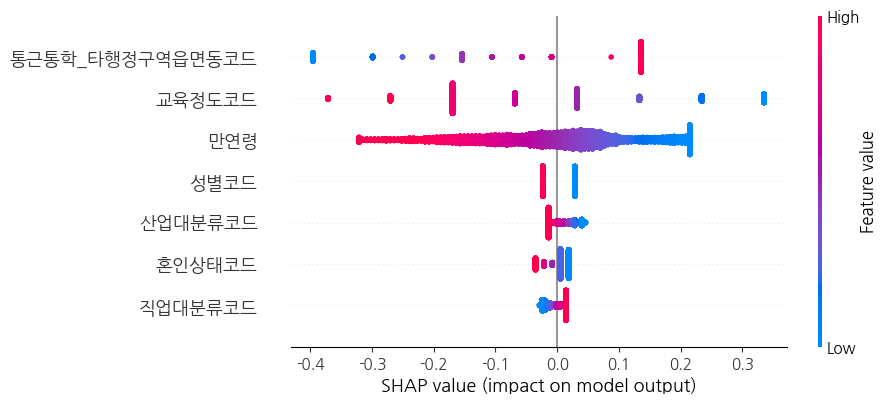


[📊 로지스틱 회귀 성능 평가]
              precision    recall  f1-score       support
0.0            0.562559  0.428520  0.486475   5540.000000
1.0            0.576455  0.700081  0.632282   6155.000000
accuracy       0.571441  0.571441  0.571441      0.571441
macro avg      0.569507  0.564301  0.559379  11695.000000
weighted avg   0.569872  0.571441  0.563212  11695.000000

[📌 로지스틱 회귀 계수 중요도]
           Feature  Coefficient
2           교육정도코드    -0.100837
1             성별코드    -0.052031
6  통근통학_타행정구역읍면동코드     0.048277
3           혼인상태코드    -0.013418
0              만연령    -0.006302
4          직업대분류코드     0.004253
5          산업대분류코드    -0.002837


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt


# 데이터 불러오기
df = pd.read_csv("인구주택총조사_2%_인구사항(제공)_2020.csv", encoding='cp949')  # 실제 파일명으로 수정하세요

def classify_movement(row):
    if (row['1년전거주지_타시도행정구역코드'] not in [31, 11,23]) and (row['행정구역시도코드'] in [31, 11,23]):
        return 1  # 비수도권 → 수도권
    elif (row['1년전거주지_타시도행정구역코드'] in [31, 11,23]) and (row['행정구역시도코드'] in [31, 11,23]):
        return 0  # 수도권 내 이동
    else:
        return None  # 제외

df['이동유형'] = df.apply(classify_movement, axis=1)
df = df.dropna(subset=['이동유형'])
# 사용 피처 지정
features = [
    '만연령', '성별코드', '교육정도코드', '혼인상태코드',
    '직업대분류코드', '산업대분류코드', '통근통학_타행정구역읍면동코드'
]
target = '이동유형'

X = df[features].copy()
y = df[target]

# 범주형 변수 인코딩
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 학습 및 로지스틱 회귀
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

# 성능 평가
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 회귀 계수 정리
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# SHAP 분석
explainer = shap.Explainer(logit, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

# SHAP 요약 시각화
shap.plots.beeswarm(shap_values, max_display=10)

print("\n[📊 로지스틱 회귀 성능 평가]")
print(report_df)

print("\n[📌 로지스틱 회귀 계수 중요도]")
print(coef_df)

In [10]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/e5/bb/dc75933de86e6076f58cf68325877be952a97a371c26b252013f1258a5a7/shap-0.47.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   -- ------------------------------------- 30.7/544.4 kB 1.3 MB/s eta 0:00:01
   ------------------ --------------------- 256.0/544.4 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 544.4/544.4 kB 4.9 MB/s eta 0:00:00


In [15]:
# 필요한 추가 변수 리스트
added_columns = [
    # 2번: 경제활동 관련
    '경제활동상태코드', '종사상지위코드', '현직업근무년수코드',
    # 4번: 가족 및 자녀 관련
    '추가자녀계획유무', '추가계획자녀수', '경력단절유무',
    # 5번: 사회활동 관련
    '사회활동_사회분야단체_참여및활동여부',
    '사회활동_경제분야단체_참여및활동여부',
    '사회활동_문화분야단체_참여및활동여부',
    '사회활동_정치분야단체_참여및활동여부',
    '사회활동_종교분야단체_참여및활동여부',
    '사회활동_지역단체_참여및활동여부',
    '사회활동_친목단체_참여및활동여부',
    '사회활동_교육단체_참여및활동여부',
    '사회활동_기타_참여및활동여부',
    '사회활동_없음_참여및활동여부'
]

# 기존 사용했던 기본 변수 리스트
base_columns = [
    '만연령', '성별코드', '교육정도코드', '혼인상태코드',
    '직업대분류코드', '산업대분류코드', '통근통학_타행정구역읍면동코드'
]

# 전체 피처 구성
all_features = base_columns + added_columns

# 누락된 컬럼 있는지 확인
missing_cols = [col for col in all_features if col not in df.columns]

missing_cols


[]

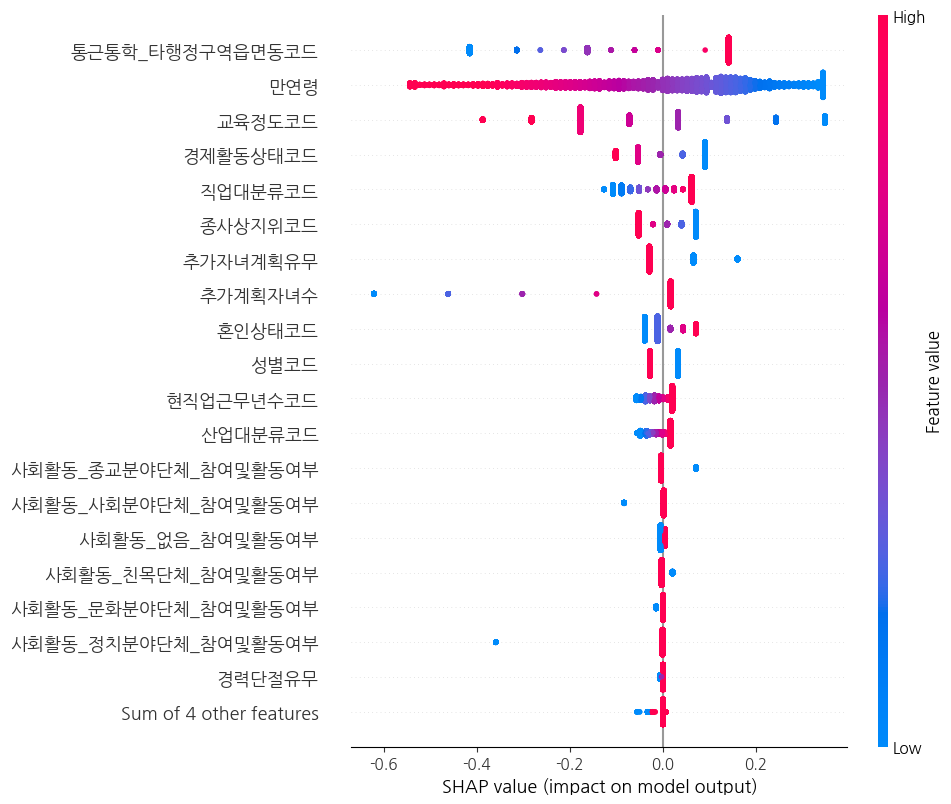


[📊 로지스틱 회귀 성능 평가]
              precision    recall  f1-score       support
0.0            0.563472  0.451083  0.501053   5540.000000
1.0            0.581129  0.685459  0.628997   6155.000000
accuracy       0.574434  0.574434  0.574434      0.574434
macro avg      0.572301  0.568271  0.565025  11695.000000
weighted avg   0.572765  0.574434  0.568389  11695.000000

[📌 로지스틱 회귀 계수 중요도]
                Feature  Coefficient
16  사회활동_정치분야단체_참여및활동여부     0.358492
21      사회활동_기타_참여및활동여부    -0.286094
11              추가계획자녀수     0.159549
2                교육정도코드    -0.105115
10             추가자녀계획유무    -0.094833
13  사회활동_사회분야단체_참여및활동여부     0.085408
17  사회활동_종교분야단체_참여및활동여부    -0.075386
1                  성별코드    -0.059939
6       통근통학_타행정구역읍면동코드     0.050644
7              경제활동상태코드    -0.047936
18    사회활동_지역단체_참여및활동여부     0.033256
8               종사상지위코드    -0.030672
3                혼인상태코드     0.027502
19    사회활동_친목단체_참여및활동여부    -0.023235
20    사회활동_교육단체_참여및활동여부     0.022755
4               직업대분류

In [16]:
# ✅ 전체 피처 구성 (기존 + 2번, 4번, 5번)
all_features = [
    # 기본
    '만연령', '성별코드', '교육정도코드', '혼인상태코드',
    '직업대분류코드', '산업대분류코드', '통근통학_타행정구역읍면동코드',
    
    # 2번: 경제활동 관련
    '경제활동상태코드', '종사상지위코드', '현직업근무년수코드',

    # 4번: 가족 및 자녀 관련
    '추가자녀계획유무', '추가계획자녀수', '경력단절유무',

    # 5번: 사회활동 참여 여부
    '사회활동_사회분야단체_참여및활동여부',
    '사회활동_경제분야단체_참여및활동여부',
    '사회활동_문화분야단체_참여및활동여부',
    '사회활동_정치분야단체_참여및활동여부',
    '사회활동_종교분야단체_참여및활동여부',
    '사회활동_지역단체_참여및활동여부',
    '사회활동_친목단체_참여및활동여부',
    '사회활동_교육단체_참여및활동여부',
    '사회활동_기타_참여및활동여부',
    '사회활동_없음_참여및활동여부'
]

target = '이동유형'

# ✅ 전체 피처 데이터셋 구성
X = df[all_features].copy()
y = df[target]

# ✅ 인코딩: object뿐 아니라 int형 명목 변수도 처리
for col in X.columns:
    if X[col].dtype == 'object' or X[col].nunique() < 10:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))  # 범주형으로 변환

# ✅ 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

# ✅ 성능 출력
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# ✅ 계수 정리
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# ✅ SHAP 해석
explainer = shap.Explainer(logit, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

# ✅ SHAP 요약 시각화
shap.plots.beeswarm(shap_values, max_display=20)

# ✅ 출력
print("\n[📊 로지스틱 회귀 성능 평가]")
print(report_df)

print("\n[📌 로지스틱 회귀 계수 중요도]")
print(coef_df)


In [17]:
from IPython.display import display
display(report_df)
display(coef_df)

,precision,recall,f1-score,support
0.0,0.563472,0.451083,0.501053,5540.000000
1.0,0.581129,0.685459,0.628997,6155.000000
accuracy,0.574434,0.574434,0.574434,0.574434
macro avg,0.572301,0.568271,0.565025,11695.000000
weighted avg,0.572765,0.574434,0.568389,11695.000000


,Feature,Coefficient
16,사회활동_정치분야단체_참여및활동여부,0.358492
21,사회활동_기타_참여및활동여부,-0.286094
11,추가계획자녀수,0.159549
2,교육정도코드,-0.105115
10,추가자녀계획유무,-0.094833
13,사회활동_사회분야단체_참여및활동여부,0.085408
17,사회활동_종교분야단체_참여및활동여부,-0.075386
1,성별코드,-0.059939
6,통근통학_타행정구역읍면동코드,0.050644
7,경제활동상태코드,-0.047936


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import shap

# all_features 및 target은 이미 정의되어 있다고 가정
X = df[all_features].copy()
y = df[target]

for col in X.columns:
    if X[col].dtype == 'object' or X[col].nunique() < 10:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

explainer = shap.Explainer(logit, X_train, feature_names=X.columns)
shap_values = explainer(X_test)


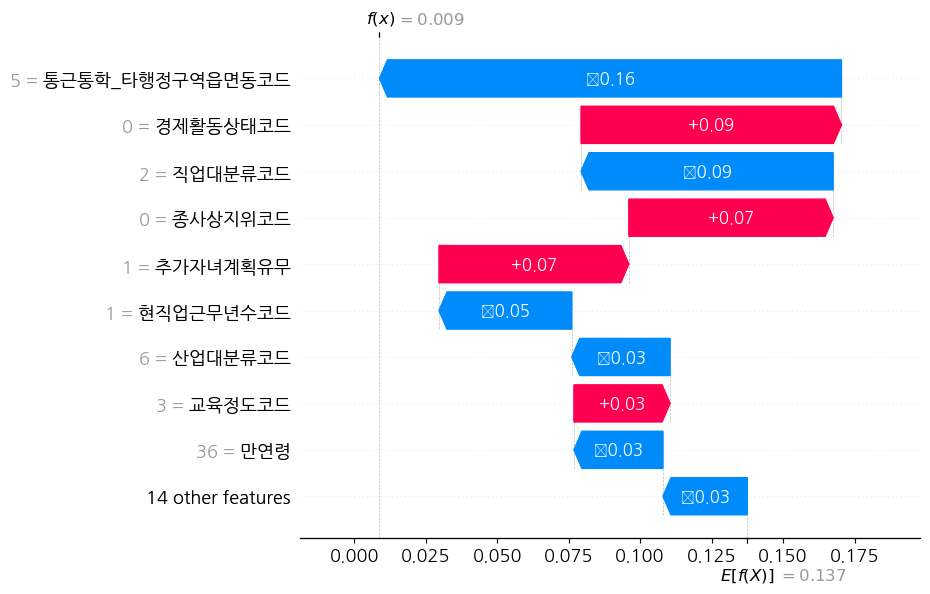

In [21]:
import numpy as np

# 유입자로 예측된 샘플 중 하나 선택
sample_index = np.where((y_test == 1) & (y_pred == 1))[0][0]
sample = X_test.iloc[sample_index]
# 샘플을 2차원 형태로 변환
sample_reshaped = sample.to_frame().T  # 또는 sample.values.reshape(1, -1)

# SHAP 값 계산
shap_value_single = explainer(sample_reshaped)

# Waterfall plot 시각화
shap.plots.waterfall(shap_value_single[0])


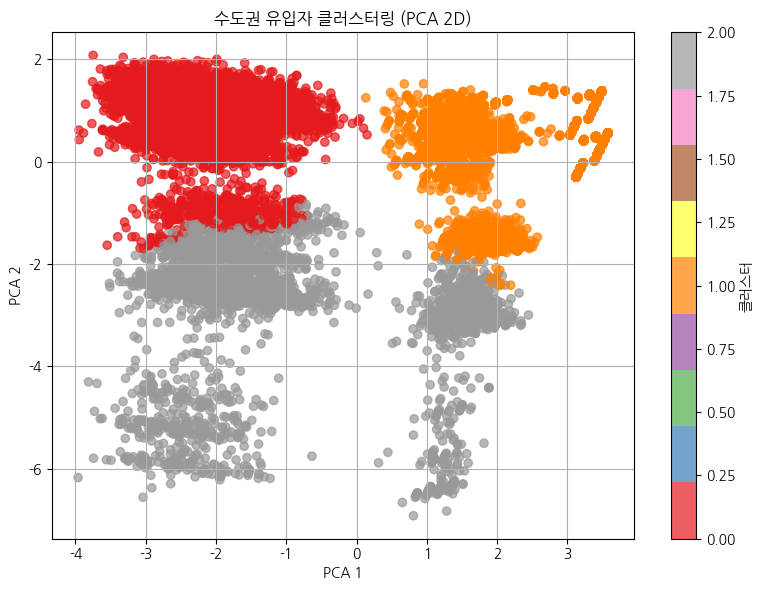

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 수도권 유입자만 필터링
inflow_df = df[df['이동유형'] == 1].copy()
X_inflow = inflow_df[all_features]

# 인코딩 (LabelEncoder 적용)
for col in X_inflow.columns:
    if X_inflow[col].dtype == 'object' or X_inflow[col].nunique() < 10:
        le = LabelEncoder()
        X_inflow[col] = le.fit_transform(X_inflow[col].astype(str))

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_inflow)

# 클러스터링 (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
inflow_df['클러스터'] = clusters

# 차원 축소 (PCA 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', alpha=0.7)
plt.title("수도권 유입자 클러스터링 (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="클러스터")
plt.grid(True)
plt.tight_layout()
plt.show()
# 클러스터별 대표 통계 보기



In [24]:
inflow_df.groupby('클러스터')[[
    '만연령', '교육정도코드', '혼인상태코드', '추가자녀계획유무', '경제활동상태코드'
]].mean()


,만연령,교육정도코드,혼인상태코드,추가자녀계획유무,경제활동상태코드
클러스터,,,,,
0,37.871955,5.322997,1.561381,2.0,1.136261
1,23.144668,3.167568,1.558446,2.0,3.999819
2,45.634921,5.03601,2.31746,1.841033,2.305852


In [27]:
inflow_df.groupby('클러스터')[[
    '만연령', '교육정도코드', '혼인상태코드', '추가자녀계획유무', '경제활동상태코드'
]].mean()

,만연령,교육정도코드,혼인상태코드,추가자녀계획유무,경제활동상태코드
클러스터,,,,,
0,38.841865,5.269295,1.713759,1.868101,1.162174
1,3.883531,1.351776,4.0,NaN,4.0
2,40.566249,4.723366,1.70009,1.905697,3.997016
3,44.080191,5.287839,1.82581,1.901923,1.828996
